# Differential Privacy: Theory and Fundamental Properties

Welcome to the third notebook in this module! In past notebooks, we explored how language models can display unintended **memorization** of private information that they are trained on. We then explored **differential privacy** and how we can use it to create machine learning models that keep *individual* data points **private**.

In this notebook, we will dive into the theoretical side of differential privacy! We will explore the formal definition of differential privacy and learn how we can calculate the right amount of noise to add. We'll learn how differential privacy handles malicious queries and what the sequential / parallel composition tradeoff is. This is pretty cutting-edge stuff!



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

## Exploring our data

In this notebook, we'll use a dataset containing information about various adults' **personal identifying information** (PII). (Don't worry, all the data is fictional!) Run the below cell to load our dataset.

In [ ]:

!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Differential%20Privacy/adult_with_pii.csv"
adult = pd.read_csv("adult_with_pii.csv")
# adult = pd.read_csv("https://raw.githubusercontent.com/uvm-plaid/programming-dp/master/notebooks/adult_with_pii.csv")

--2021-08-07 16:27:04--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Differential%20Privacy/adult_with_pii.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4910401 (4.7M) [application/vnd.ms-excel]
Saving to: ‘adult_with_pii.csv’

adult_with_pii.csv  100%[===================>]   4.68M  --.-KB/s    in 0.03s   

2021-08-07 16:27:04 (177 MB/s) - ‘adult_with_pii.csv’ saved [4910401/4910401]



**Exercise**: Print out the first five rows of our dataset.

In [ ]:
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**Question**: Which columns in this dataset contain personal identifying information?

In [ ]:
adult_pii = adult[["Name", "DOB", "SSN", "Zip"]] ## TODO: Replace None with the column names


Identifying information has no formal definition. It is usually understood to be information which would be used to identify us uniquely in the course of daily life - name, address, phone number, e-mail address, etc. As we will see later, it's impossible to formalize the concept of identifying information, because all information is identifying. The term personally identifiable information (PII) is often used synonymously with identifying information.

How do we de-identify information? Easy - we just remove the columns that contain identifying information!

**Exercise**: Drop the columns corresponding to `"Name"` and `"SSN"`.

**Hint**: Look into the `drop` function.

In [ ]:
adult_data = adult.copy()

adult_data = adult_data.drop(['Name', 'SSN'], axis=1)
adult_data.head(1)

,DOB,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


We'll save some of the identifying information for later, when we'll use it as auxiliary data to perform a re-identification attack.

## Linking Attacks

Imagine we want to determine the income of a friend from our de-identified data. Names have been removed, but we happen to know some **auxiliary information** about our friend. Our friend's name is Karrie Trusslove, and we know Karrie's date of birth and zip code.

To perform a simple **linking attack**, we look at the overlapping columns between the dataset we're trying to attack, and the auxiliary data we know. In this case, both datasets have dates of birth and zip codes. We look for rows in the dataset we're attacking with dates of birth and zip codes that match Karrie's date of birth and zip code. If there is only one such row, we've found Karrie's row in the dataset we're attacking. In databases, this is called a join of two tables, and we can do it in Pandas using `merge`.

**Exercise**: Use the `merge` function to find the row in our data corresponding to Karrie Trusslove's auxiliary data(`DOB` and `Zip`).

In [ ]:
karries_row = adult_pii[adult_pii['Name'] == 'Karrie Trusslove']

adult_data.merge(karries_row, on=['DOB', 'Zip'])


,DOB,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Name,SSN
0,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Karrie Trusslove,732-14-6110



**Question**: Were we able to re-identify Karrie? If so, what is Karrie's income?

This scenario is made up, but linking attacks are surprisingly easy to perform in practice. How easy? It turns out that in many cases, just one data point is sufficient to pinpoint a row!

**Exercise:** Use the `merge` function again, this time to find the row in our data corresponding only to Karrie Trusslove's `Zip`.

In [ ]:


karries_row = adult_pii[adult_pii['Zip'] == 64152]

adult_data.merge(karries_row, on='Zip')

,DOB_x,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Name,DOB_y,SSN
0,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Karrie Trusslove,9/7/1967,732-14-6110


**Question**: Can we re-identify Karrie by ZIP code alone?

**Exercise**: Finally, use the `merge` function to find the row in our data corresponding only to Karrie Trusslove's `DOB`.

In [ ]:

karries_row = adult_pii[adult_pii['DOB'] ==	'9/7/1967']

adult_data.merge(karries_row, on='DOB')

,DOB,Zip_x,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Name,SSN,Zip_y
0,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Karrie Trusslove,732-14-6110,64152
1,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Kyle Lynas,748-95-9708,67306
2,9/7/1967,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Arlyn Skivington,579-69-0687,62254
3,9/7/1967,67306,64,Private,171373,11th,7,Widowed,Farming-fishing,Unmarried,White,Female,0,0,40,United-States,<=50K,Karrie Trusslove,732-14-6110,64152
4,9/7/1967,67306,64,Private,171373,11th,7,Widowed,Farming-fishing,Unmarried,White,Female,0,0,40,United-States,<=50K,Kyle Lynas,748-95-9708,67306
5,9/7/1967,67306,64,Private,171373,11th,7,Widowed,Farming-fishing,Unmarried,White,Female,0,0,40,United-States,<=50K,Arlyn Skivington,579-69-0687,62254
6,9/7/1967,62254,46,Self-emp-not-inc,119944,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K,Karrie Trusslove,732-14-6110,64152
7,9/7/1967,62254,46,Self-emp-not-inc,119944,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K,Kyle Lynas,748-95-9708,67306
8,9/7/1967,62254,46,Self-emp-not-inc,119944,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K,Arlyn Skivington,579-69-0687,62254


**Question**: Can we re-identify Karrie by date of birth alone? If not, how much information were we able to gain?

How hard is it to re-identify others in the dataset? Is Karrie especially easy or especially difficult to re-identify? A good way to gauge the effectiveness of this type of attack is to look at how "selective" certain pieces of data are - how good they are at narrowing down the set of potential rows which may belong to the target individual. For example, is it common for birthdates to occur more than once?

We'd like to get an idea of how many dates of birth are likely to be useful in performing an attack, which we can do by looking at how common "unique" dates of birth are in the dataset.

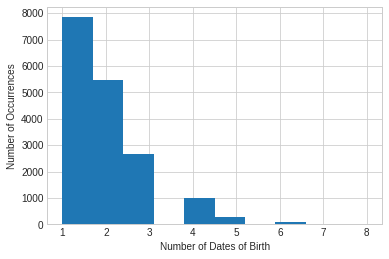

In [ ]:

adult_pii['DOB'].value_counts() .hist()
plt.xlabel('Number of Dates of Birth')
plt.ylabel('Number of Occurrences');

**Question**: On average, how many occurrences will there be of a single birthday in our dataset?

**Question**: Is filtering by date of birth effective in narrowing down the possible records for an individual?

We can do the same thing with Zip codes.

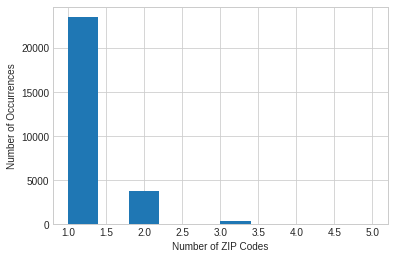

In [ ]:

adult_pii['Zip'].value_counts().hist()
plt.xlabel('Number of ZIP Codes')
plt.ylabel('Number of Occurrences');

**Question**: On average, how many occurrences will there be of a single Zip code in our dataset?

**Question**: Is filtering by Zip code effective in narrowing downthe possible records for an individual?

**How Many People can we Re-Identify?**

In this dataset, how many people can we re-identify uniquely? We can use our auxiliary information to find out! Let's see what happens when we filter by both date of birth and Zip code.

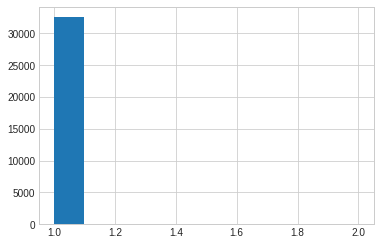

In [ ]:

attack = pd.merge(adult_pii, adult_data, left_on=['DOB', 'Zip'], right_on=['DOB', 'Zip'])
attack['Name'].value_counts().hist();

**Question**: How many people were we able to re-identify uniquely when filtering by date of birth / Zip code pairs? Does this result surprise you?

## Differential Privacy (A Formal Definition)

A function which satisfies differential privacy is often called a **mechanism**. We say that a mechanism $F$ satisfies differential privacy if for all neighboring datasets $x$ and $x'$, and all possible outputs $S$,

$$
\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = S]} \leq e^\epsilon
$$

Two datasets are considered **neighbors** if they differ in the data of a single individual. Note that $F$ is typically a randomized function, so that the probability distribution describing its outputs is not just a point distribution.

The important implication of this definition is that $F$'s output will be pretty much the same, with or without the data of any specific individual. In other words, the randomness built into $F$ should be "enough" so that an observed output from $F$ will not reveal which of $x$ or $x'$ was the input. Imagine that my data is present in $x$ but not in $x'$. If an adversary can't determine which of $x$ or $x'$ was the input to $F$, then the adversary can't tell whether or not my data was present in the input - let alone the contents of that data.

The $\epsilon$ parameter in the definition is called the **privacy parameter** or the privacy budget. $\epsilon$ provides a knob to tune the "amount of privacy" the definition provides. Small values of $\epsilon$ require $F$ to provide very similar outputs when given similar inputs, and therefore provide higher levels of privacy; large values of $\epsilon$ allow less similarity in the outputs, and therefore provide less privacy.

How should we set $\epsilon$ to prevent bad outcomes in practice? Nobody knows. The general consensus is that $\epsilon$ should be around 1 or smaller, and values of $\epsilon$ above 10 probably don't do much to protect privacy - but this rule of thumb could turn out to be very conservative. In general, you can treat $\epsilon$ as another hyperparameter to train.

## The Laplace Mechanism

Let's first consider what a query might look like without differential privacy. Here's how we might query "How many individuals in the dataset are 40 years old or older?"

In [ ]:
adult[adult['Age'] >= 40].shape[0]

**Exercise**: Now, to get practice for writing queries, try to write your own query for "How many individuals in the dataset work 30 hours per week or less?"

In [ ]:

adult[adult['Hours per week'] <= 30].shape[0]

5245

The easiest way to achieve differential privacy for this query is to add random noise to its answer. The key challenge is to add enough noise to satisfy the definition of differential privacy, but not so much that the answer becomes too noisy to be useful. To make this process easier, some basic mechanisms have been developed in the field of differential privacy, which describe exactly what kind of - and how much - noise to use. One of these is called the **Laplace mechanism**.

According to the Laplace mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $\epsilon$-differential privacy:

$$
F(x) = f(x) + \textsf{Lap}(\frac{s}{\epsilon})
$$

where $s$ is the **sensitivity** of $f$, and $\textsf{Lap}(S)$ denotes sampling from the **Laplace distribution** with center 0 and scale $S$.

![link](https://i.stack.imgur.com/jgdDT.png)

The sensitivity of a function $f$ is the amount $f$'s output changes when its input changes by 1. Sensitivity is a complex topic, and an integral part of designing differentially private algorithms; we will have much more to say about it later.

**Question**: As a quick conceptual check, what is the sensitivity of a query which counts the number of rows in the dataset with a particular property?

Thus we can achieve differential privacy for our example query by using the Laplace mechanism with sensitivity 1 and an $\epsilon$ of our choosing. For now, let's pick $\epsilon = 0.1$. We can sample from the Laplace distribution using Numpy's `random.laplace` function.

**Exercise**: First, query the number of individuals in the dataset who are 40 years old or older (we did this earlier!). Then, add a random sample (`np.random.laplace`) from the Laplace distribution mentioned earlier to this result. Print out your final result.

In [ ]:
sensitivity = 1
epsilon = 0.1


adult[adult['Age'] >= 40].shape[0] + np.random.laplace(scale=sensitivity/epsilon)


14231.31545821962

**Question**: Try running this cell multiple times! Each time, you should notice that the output will change. Why is the answer useful even though the result changes?

**Question**: Next, try changing the `epsilon` value. How does that affect your output?

## Handling Malicious Queries

How do we know that the Laplace mechanism adds enough noise to prevent the re-identification of individuals in the dataset? For one thing, we can try to break it! In this exercise, we will try writing a malicious query, both without and with our differential privacy mechanism, to see what result we get.

**Exercise**: First, write a query to determine whether Karrie Trusslove has an income less than or equal to \$50k.

In [ ]:
karries_row = adult[adult['Name'] == 'Karrie Trusslove']
if karries_row['Target'].values == '<=50K':
  print("True")
else:
  print("False")


True


**Question**: Does this query violate Karrie's privacy? Why or why not?

Now that we have executed our query without differential privacy, let's see what our malicious query returns if we use our Laplace mechanism!

**Exercise**: Next, you should first copy in the query you wrote to determine whether Karrie Trusslove has an income less than or equal to \$50k. However, you should then add a random sample (`np.random.laplace`) from the Laplace distribution mentioned earlier to this result. Print out your final result.

In [ ]:
epsilon = 0.1
mean = 0

karries_row = adult[adult['Name'] == 'Karrie Trusslove']
karries_row[karries_row['Target'] == '<=50K'].shape[0] +np.random.laplace(scale=sensitivity/epsilon)
for i in range(10000):
  mean += karries_row[karries_row['Target'] == "<=50K"].shape[0] + np.random.laplace(scale=sensitivity/epsilon)
mean /= 100000
print(mean)



0.10582403308485573


**Question**: Does this modified query violate Karrie's privacy? Why or why not?

## Sequential Composition

One major property of differential privacy which we should discuss is **sequential composition**, which bounds the total privacy cost of releasing multiple results of differentially private mechanisms on the same input data. Formally, the sequential composition theorem for differential privacy says that:

> If $F_1(x)$ satisfies $\epsilon_1$-differential privacy

> And $F_2(x)$ satisfies $\epsilon_2$-differential privacy

> Then the mechanism $G(x) = (F_1(x), F_2(x))$ which releases both results satisfies $\epsilon_1+\epsilon_2$-differential privacy

Sequential composition is a vital property of differential privacy because it enables the design of algorithms that consult the data more than once. Sequential composition is also important when multiple separate analyses are performed on a single dataset, since it allows individuals to bound the total privacy cost they incur by participating in all of these analyses. The bound on privacy cost given by sequential composition is an *upper bound* - the actual privacy cost of two particular differentially private releases may be smaller than this, but never larger.

The principle that the $\epsilon$s "add up" makes sense if we examine the distribution of outputs from a mechanism which averages two differentially private results together. Let's look at some examples.

In [ ]:
epsilon1 = 1
epsilon2 = 1
epsilon_total = 2

# satisfies 1-differential privacy
def F1():
    return np.random.laplace(loc=0, scale=1/epsilon1)

# satisfies 1-differential privacy
def F2():
    return np.random.laplace(loc=0, scale=1/epsilon2)

# satisfies 2-differential privacy
def F3():
    return np.random.laplace(loc=0, scale=1/epsilon_total)

# satisfies 2-differential privacy, by sequential composition
def F_combined():
    return (F1() + F2()) / 2

In [ ]:


# plot F1
plt.hist([F1() for i in range(1000)], bins=50, label='F1');

# plot F2 (should look the same)
plt.hist([F2() for i in range(1000)], bins=50, alpha=.7, label='F2');
plt.legend();

**Question**: How does F1 compare to F2? Is it similar or dissimilar?

**Question**: What does the similarity/dissimilarity of F1 and F2 tell us about how much privacy they preserve? Is this consistent with their epsilon values?

Next, let's compare the graphs of F1 and F3.

In [ ]:

# plot F1
plt.hist([F1() for i in range(1000)], bins=50, label='F1');

# plot F3 (should look "pointier")
plt.hist([F3() for i in range(1000)], bins=50, alpha=.7, label='F3');
plt.legend();

**Question**: How does F1 compare to F3? Is it similar or dissimilar?

**Question**: What does the similarity/dissimilarity of F1 and F3 tell us about how much privacy they preserve? Is this consistent with their epsilon values?

Finally, let's compare the graphs of F3 and F_combined. **Before you run the below cell, answer this question.**

**Question**: If you recall, the $\epsilon$ values for these two mechanisms are the same - both have an $\epsilon$ of 2. What do you hypothesize their output distributions will look like?

In [ ]:

# plot F1
plt.hist([F3() for i in range(1000)], bins=50, label='F3');

# plot F_combined (should look "pointier")
plt.hist([F_combined() for i in range(1000)], bins=50, alpha=.7, label='F_combined');
plt.legend();

**Question**: How does F3 compare to F_combined? Is it similar or dissimilar?

**Question**: Any guesses why this might be the case? (Hint: think back to our definition of sequential composition and *upper bounding*)

## Parallel Composition

The second important property of differential privacy is called **parallel composition**. Parallel composition can be seen as an alternative to sequential composition - a second way to calculate a bound on the total privacy cost of multiple data releases. Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Since the chunks are disjoint, each individual's data appears in exactly one chunk - so even if there are $k$ chunks in total (and therefore $k$ runs of the mechanism), the mechanism runs exactly once on the data of each individual. Formally,

> If $F(x)$ satisfies $\epsilon$-differential privacy

> And we split a dataset $X$ into $k$ disjoint chunks such that $x_1 \cup ... \cup x_k = X$

> Then the mechanism which releases all of the results $F(x_1), ..., F(x_k)$ satisfies $\epsilon$-differential privacy

**Question**: How does the bound on privacy for parallel composition compare to that of sequential composition? Any intuition for why this is the case?

### Optional: Histograms

In our context, a **histogram** is an analysis of a dataset which splits the dataset into "bins" based on the value of one of the data attributes, and counts the number of rows in each bin. For example, a histogram might count the number of people in the dataset who achieved a particular educational level.

In [ ]:

adult['Education'].value_counts().to_frame().head(5)

Histograms are particularly interesting for differential privacy because they automatically satisfy parallel composition. Each "bin" in a histogram is defined by a possible value for a data attribute (for example, 'Education' == 'HS-grad'). It's impossible for a single row to have two values for an attribute simultaneously, so defining the bins this way guarantees that they will be disjoint. Thus we have satisfied the requirements for parallel composition, and we can use a differentially private mechanism to release all of the bin counts with a total privacy cost of just $\epsilon$.

Run the below cell to add random noise from the Laplace distribution to our histogram. We won't ask you to code this part but take a look at the code to see how it works!

In [ ]:
epsilon = 1

# This analysis has a total privacy cost of epsilon = 1, even though we release many results!
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
s = adult['Education'].value_counts().apply(f)
s.to_frame().head(5)

### Optional: Contingency Tables

A **contingency table** or cross tabulation (often shortened to crosstab) is like a multi-dimensional histogram. It counts the frequency of rows in the dataset with particular values for more than one attribute at a time. Contingency tables are frequently used to show the relationship between two variables when analyzing data. For example, we might want to see counts based on both education level and gender:

In [ ]:

pd.crosstab(adult['Education'], adult['Sex']).head(5)

Like the histogram we saw earlier, each individual in the dataset participates in exactly one count appearing in this table. It's impossible for any single row to have multiple values simultaneously, for any set of data attributes considered in building the contingency table. As a result, it's safe to use parallel composition here, too.

In [ ]:
ct = pd.crosstab(adult['Education'], adult['Sex'])
f = lambda x: x + np.random.laplace(loc=0, scale=1/epsilon)
ct.applymap(f).head(5)

It's also possible to generate contingency tables of more than 2 variables. However, it is important to consider what effect that might have on our differential privacy mechanism.

**Question**: When we add a new variable to our contingency table, what happens to our existing counts?

**Question**: How does this affect the accuracy of our differentially private results? (Hint: recall what happened to malicious queries which tried to extract info about a single individual!)

## Conclusion

Great job! In this notebook, we took a look at some fundamental theory behind differential privacy. You learned how linking attacks can be conducted, thus proving the need for differential privacy. You then discussed how we can formally define differential privacy and how we can generate it using a Laplace distribution. You learned how differential privacy is able to effectively handle malicious queries. And you learned about sequential and parallel composition and how they compare, with their tradeoff between privacy and accuracy. See you all next time!